In [4]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data import Dataset, DataLoader


In [2]:

class SimpleNeuralNetwork:
    def __init__(self):
        # Initialize weights and biases
        self.w1 = np.random.randn(2, 3)  # Weights: 2 inputs to 3 hidden neurons
        self.b1 = np.zeros((1, 3))       # Biases for hidden layer
        self.w2 = np.random.randn(3, 1)  # Weights: 3 hidden neurons to 1 output
        self.b2 = np.zeros((1, 1))       # Bias for output layer

    def relu(self, x):
        return np.maximum(0, x)

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def forward(self, X):
        # Forward pass
        self.z1 = np.dot(X, self.w1) + self.b1  # Hidden layer input
        self.a1 = self.relu(self.z1)            # Hidden layer output
        self.z2 = np.dot(self.a1, self.w2) + self.b2  # Output layer input
        self.a2 = self.sigmoid(self.z2)         # Output layer output
        return self.a2

# Create sample input data
X = np.array([[0.5, 0.8]])  # 1 sample with 2 features

# Initialize and run the network
nn = SimpleNeuralNetwork()
output = nn.forward(X)
print(f"Output of the network: {output}")

# Visualization of the network structure
def plot_neural_network():
    fig, ax = plt.subplots(figsize=(8, 6))

    # Define neuron positions
    layers = [
        [(0.1, 0.7), (0.1, 0.3)],           # Input layer (2 neurons)
        [(0.5, 0.8), (0.5, 0.5), (0.5, 0.2)],  # Hidden layer (3 neurons)
        [(0.9, 0.5)]                        # Output layer (1 neuron)
    ]

    # Draw neurons
    for layer in layers:
        for x, y in layer:
            circle = plt.Circle((x, y), 0.05, color='blue', fill=True)
            ax.add_patch(circle)

    # Draw connections
    for i in range(len(layers)):
        for n1 in layers[i]:
            if i < len(layers) - 1:
                for n2 in layers[i + 1]:
                    ax.plot([n1[0], n2[0]], [n1[1], n2[1]], 'k-', lw=0.5)

    # Labels
    ax.text(0.1, 0.75, 'Input 1', ha='center', va='bottom')
    ax.text(0.1, 0.35, 'Input 2', ha='center', va='bottom')
    ax.text(0.5, 0.85, 'H1', ha='center', va='bottom')
    ax.text(0.5, 0.55, 'H2', ha='center', va='bottom')
    ax.text(0.5, 0.25, 'H3', ha='center', va='bottom')
    ax.text(0.9, 0.55, 'Output', ha='center', va='bottom')

    # Set limits and remove axes
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.axis('off')
    plt.title("Simple Neural Network Structure")
    plt.show()



Output of the network: [[0.5]]


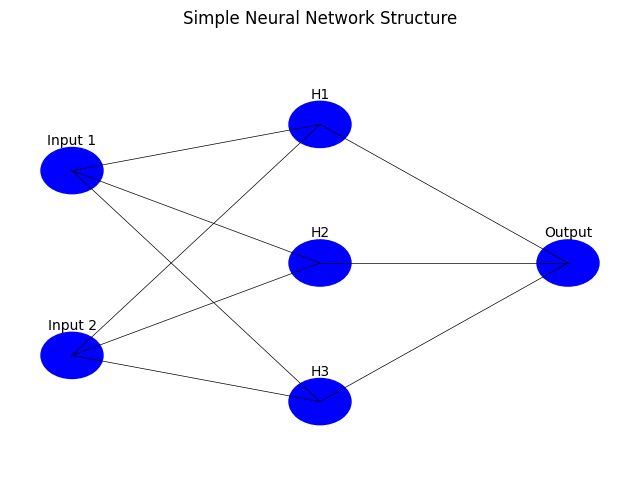

In [3]:
# Call the visualization function
plot_neural_network()

In [5]:

class MarchMadnessDataset(Dataset):
    """
    Dataset for March Madness tournament teams
    
    Each input is structured as:
    [team1_available, team1_seed, team1_opponent_seed, team1_feature4, 
     team2_available, team2_seed, team2_opponent_seed, team2_feature4,
     ...
     teamN_available, teamN_seed, teamN_opponent_seed, teamN_feature4]
    
    Output is a selection of 5 teams (indices of selected teams)
    """
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

class MarchMadnessNN(nn.Module):
    def __init__(self, num_teams, hidden_size=128):
        """
        Initialize the neural network.
        
        Args:
            num_teams: Number of teams in tournament
            hidden_size: Size of hidden layer
        """
        super(MarchMadnessNN, self).__init__()
        
        self.num_teams = num_teams
        input_size = num_teams * 4  # 4 features per team
        
        self.model = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size // 2),
            nn.ReLU(),
            nn.Linear(hidden_size // 2, 5 * num_teams)  # Output logits for each team selection
        )
        
    def forward(self, x):
        """
        Forward pass through the network.
        
        The output is reshaped to (batch_size, 5, num_teams) where:
        - 5 is the number of team selections
        - num_teams is the total number of teams
        
        This allows us to select 5 different teams using softmax across the team dimension.
        """
        batch_size = x.size(0)
        logits = self.model(x)
        
        # Reshape to (batch_size, 5, num_teams) for team selection
        logits = logits.view(batch_size, 5, self.num_teams)
        
        # Apply softmax for each selection slot
        team_probabilities = torch.softmax(logits, dim=2)
        
        return team_probabilities

def train_model(model, train_loader, val_loader, num_epochs=50, learning_rate=0.001):
    """
    Train the March Madness team selection model
    
    Args:
        model: The neural network model
        train_loader: DataLoader for training data
        val_loader: DataLoader for validation data
        num_epochs: Number of training epochs
        learning_rate: Learning rate for optimizer
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    # Custom loss function to ensure 5 different teams are selected
    def team_selection_loss(output, target):
        # Calculate cross-entropy loss for each of the 5 selections
        loss = 0
        for i in range(5):
            # Get prediction for selection i
            selection_probs = output[:, i, :]
            # Get target for selection i
            selection_target = target[:, i, :]
            # Calculate loss for this selection
            selection_loss = nn.CrossEntropyLoss()(selection_probs, selection_target.argmax(dim=1))
            loss += selection_loss
            
        # Add regularization to discourage selecting the same team multiple times
        # Calculate similarity between selections
        sim_loss = 0
        for i in range(5):
            for j in range(i+1, 5):
                sim = torch.sum(output[:, i, :] * output[:, j, :], dim=1)
                sim_loss += torch.mean(sim)
                
        return loss + 0.1 * sim_loss
    
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        
        for inputs, targets in train_loader:
            inputs = inputs.to(device)
            targets = targets.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            
            # Reshape targets to match model output format
            targets = targets.view(-1, 5, model.num_teams)
            
            loss = team_selection_loss(outputs, targets)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            
        # Validation phase
        model.eval()
        val_loss = 0.0
        
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs = inputs.to(device)
                targets = targets.to(device)
                
                outputs = model(inputs)
                
                # Reshape targets to match model output format
                targets = targets.view(-1, 5, model.num_teams)
                
                loss = team_selection_loss(outputs, targets)
                val_loss += loss.item()
                
        print(f'Epoch {epoch+1}/{num_epochs}, '
              f'Train Loss: {train_loss/len(train_loader):.4f}, '
              f'Val Loss: {val_loss/len(val_loader):.4f}')
    
    return model

def predict_teams(model, tournament_data, num_teams):
    """
    Select 5 teams from the tournament data
    
    Args:
        model: Trained neural network model
        tournament_data: Current tournament data (availability, seeds, opponents)
        num_teams: Total number of teams in tournament
    
    Returns:
        List of 5 selected team indices
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()
    
    # Convert input data to tensor
    inputs = torch.tensor(tournament_data, dtype=torch.float32).unsqueeze(0).to(device)
    
    # Get team selection probabilities
    with torch.no_grad():
        team_probabilities = model(inputs)
    
    # Get the 5 teams with highest probability
    team_selections = []
    
    # Process one selection at a time to avoid duplicates
    remaining_teams = torch.ones(num_teams, device=device)
    
    for i in range(5):
        # Mask already selected teams
        masked_probs = team_probabilities[0, i] * remaining_teams
        
        # Select the team with highest probability
        selected_team = torch.argmax(masked_probs).item()
        team_selections.append(selected_team)
        
        # Mark this team as selected (can't be selected again)
        remaining_teams[selected_team] = 0
    
    return team_selections

# Example usage
def example():
    # Example with 64 teams
    num_teams = 64
    
    # Create model
    model = MarchMadnessNN(num_teams=num_teams, hidden_size=128)
    
    # Generate some example data (you would replace this with your real data)
    # Format: [team1_available, team1_seed, team1_opponent_seed, team1_feature4, team2_available, ...]
    X_train = np.random.rand(100, num_teams * 4)
    
    # Convert availabilities to binary (0 or 1)
    for i in range(100):
        for j in range(num_teams):
            X_train[i, j*4] = np.random.choice([0, 1])
            
    # Create target selections (one-hot encoded)
    y_train = np.zeros((100, 5 * num_teams))
    for i in range(100):
        # Select 5 random teams for each sample
        selected_teams = np.random.choice(num_teams, 5, replace=False)
        for j, team in enumerate(selected_teams):
            y_train[i, j * num_teams + team] = 1
    
    # Create datasets
    train_size = int(0.8 * len(X_train))
    X_val = X_train[train_size:]
    y_val = y_train[train_size:]
    X_train = X_train[:train_size]
    y_train = y_train[:train_size]
    
    train_dataset = MarchMadnessDataset(X_train, y_train)
    val_dataset = MarchMadnessDataset(X_val, y_val)
    
    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=16)
    
    # Train model
    trained_model = train_model(model, train_loader, val_loader)
    
    # Example tournament data (current state of tournament)
    # For simplicity, let's say first 32 teams are still available
    tournament_data = np.zeros(num_teams * 4)  # Changed to 4 features per team
    for i in range(32):
        # Team is available
        tournament_data[i*4] = 1
        # Assign some seed (1-16)
        tournament_data[i*4 + 1] = (i % 16) + 1
        # Assign opponent seed
        tournament_data[i*4 + 2] = 17 - tournament_data[i*4 + 1]  # Opponent seed (e.g., 1 plays 16)
        # Fourth feature (could be any meaningful stat)
        tournament_data[i*4 + 3] = np.random.rand()  # Random value for the fourth feature
    
    # Make prediction
    selected_teams = predict_teams(trained_model, tournament_data, num_teams)
    print("Selected teams (indices):", selected_teams)
    
    # Convert to seeds for better understanding
    selected_seeds = [int(tournament_data[team*4 + 1]) for team in selected_teams]
    print("Selected team seeds:", selected_seeds)

if __name__ == "__main__":
    example()

Epoch 1/50, Train Loss: 20.8098, Val Loss: 20.8103
Epoch 2/50, Train Loss: 20.8071, Val Loss: 20.8098
Epoch 3/50, Train Loss: 20.8032, Val Loss: 20.8102
Epoch 4/50, Train Loss: 20.7950, Val Loss: 20.8117
Epoch 5/50, Train Loss: 20.7802, Val Loss: 20.8137
Epoch 6/50, Train Loss: 20.7522, Val Loss: 20.8187
Epoch 7/50, Train Loss: 20.7079, Val Loss: 20.8301
Epoch 8/50, Train Loss: 20.6693, Val Loss: 20.8483
Epoch 9/50, Train Loss: 20.6357, Val Loss: 20.8548
Epoch 10/50, Train Loss: 20.6226, Val Loss: 20.8588
Epoch 11/50, Train Loss: 20.6067, Val Loss: 20.8506
Epoch 12/50, Train Loss: 20.6005, Val Loss: 20.8502
Epoch 13/50, Train Loss: 20.5769, Val Loss: 20.8364
Epoch 14/50, Train Loss: 20.5532, Val Loss: 20.8378
Epoch 15/50, Train Loss: 20.5289, Val Loss: 20.8374
Epoch 16/50, Train Loss: 20.5101, Val Loss: 20.8331
Epoch 17/50, Train Loss: 20.4861, Val Loss: 20.8267
Epoch 18/50, Train Loss: 20.4657, Val Loss: 20.8256
Epoch 19/50, Train Loss: 20.4501, Val Loss: 20.8321
Epoch 20/50, Train Lo

In [1]:
import plotly.graph_objects as go
import random
import math

def create_tournament_bracket(teams):
    """Generate the tournament bracket structure"""
    if not teams or len(teams) < 2:
        return "Need at least 2 teams!", []
    
    # Round up to nearest power of 2
    bracket_size = 2 ** math.ceil(math.log2(len(teams)))
    while len(teams) < bracket_size:
        teams.append("BYE")
    
    random.shuffle(teams)
    current_round = teams.copy()
    bracket_history = [current_round.copy()]
    
    while len(current_round) > 1:
        next_round = []
        for i in range(0, len(current_round), 2):
            team1 = current_round[i]
            team2 = current_round[i + 1]
            winner = team1 if team2 == "BYE" else (team2 if team1 == "BYE" else random.choice([team1, team2]))
            next_round.append(winner)
        current_round = next_round
        bracket_history.append(current_round.copy())
    
    return bracket_history

def render_beautiful_bracket(bracket_history):
    """Create a beautiful interactive bracket using Plotly"""
    if not bracket_history:
        return
    
    # Calculate dimensions
    num_rounds = len(bracket_history)
    max_teams = len(bracket_history[0])
    width_per_round = 200
    height_per_team = 50
    
    # Create figure
    fig = go.Figure()
    
    # Colors and styling
    team_color = '#2ecc71'  # Green for teams
    line_color = '#3498db'  # Blue for connecting lines
    winner_color = '#e74c3c'  # Red for winners
    
    # Add each round
    for round_num, teams in enumerate(bracket_history):
        x_base = round_num * width_per_round
        num_teams = len(teams)
        spacing = max_teams * height_per_team / num_teams
        
        # Add team boxes
        for i, team in enumerate(teams):
            y_pos = (max_teams - num_teams) * height_per_team/2 + i * spacing
            
            # Team box
            fig.add_shape(
                type="rect",
                x0=x_base-90, x1=x_base+90,
                y0=y_pos-20, y1=y_pos+20,
                line=dict(color=team_color if round_num == 0 else winner_color),
                fillcolor="rgba(255, 255, 255, 0.9)",
                layer="below"
            )
            
            # Team name
            fig.add_annotation(
                x=x_base,
                y=y_pos,
                text=team,
                showarrow=False,
                font=dict(size=12, color="black"),
                align="center"
            )
            
            # Connecting lines to previous round
            if round_num > 0:
                prev_round_teams = len(bracket_history[round_num-1])
                prev_spacing = max_teams * height_per_team / prev_round_teams
                prev_y = (max_teams - prev_round_teams) * height_per_team/2 + (i*2 if i*2 < prev_round_teams else i) * prev_spacing
                
                fig.add_shape(
                    type="line",
                    x0=x_base-90, x1=x_base-width_per_round+90,
                    y0=y_pos, y1=prev_y,
                    line=dict(color=line_color, width=2)
                )
    
    # Customize layout
    fig.update_layout(
        title="Tournament Bracket",
        title_x=0.5,
        width=num_rounds * width_per_round + 100,
        height=max_teams * height_per_team + 100,
        showlegend=False,
        paper_bgcolor='rgba(240, 240, 240, 1)',
        plot_bgcolor='rgba(0,0,0,0)',
        xaxis=dict(visible=False),
        yaxis=dict(visible=False),
        margin=dict(l=50, r=50, t=100, b=50)
    )
    
    # Add round labels
    for i in range(num_rounds):
        round_name = ["Round 1", "Round 2", "Quarterfinals", "Semifinals", "Finals", "Champion"][min(i, 5)]
        fig.add_annotation(
            x=i * width_per_round,
            y=max_teams * height_per_team + 20,
            text=round_name,
            showarrow=False,
            font=dict(size=14, color="#2c3e50")
        )
    
    # Show the plot
    fig.show()
    
    # Optionally save as HTML
    fig.write_html("beautiful_bracket.html")

# Example usage
teams = [
    "Duke", "Kentucky", "Gonzaga", "Kansas",
    "UNC", "Villanova", "Arizona", "UCLA",
    "Purdue", "Baylor", "Michigan", "Illinois",
    "Tennessee", "Texas", "Ohio State", "Iowa"
]

bracket = create_tournament_bracket(teams)
render_beautiful_bracket(bracket)

## Actor and Critic Networks

In [ ]:
class ActorNetwork(nn.Module):
    """
    Actor network for the PPO algorithm.
    This network outputs action probabilities for selecting teams.
    """
    def __init__(self, num_teams, hidden_size=128):
        super(ActorNetwork, self).__init__()
        
        self.num_teams = num_teams
        input_size = num_teams * 4  # 4 features per team
        
        # Shared feature extractor
        self.feature_extractor = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size // 2),
            nn.ReLU()
        )
        
        # Separate head for each of the 5 team selections
        self.selection_heads = nn.ModuleList([
            nn.Linear(hidden_size // 2, num_teams) for _ in range(5)
        ])
        
    def forward(self, x, mask=None):
        """
        Forward pass through the network.
        
        Args:
            x: Input features of shape (batch_size, num_teams * 4)
            mask: Boolean mask of shape (batch_size, 5, num_teams) where True means the team 
                  is available for selection at that position
        
        Returns:
            List of probability distributions for each selection
        """
        batch_size = x.size(0)
        features = self.feature_extractor(x)
        
        # Get logits for each selection
        selection_dists = []
        
        for i in range(5):
            logits = self.selection_heads[i](features)
            
            # Apply masking if provided
            if mask is not None:
                # Set logits for unavailable teams to a large negative value
                mask_for_selection = mask[:, i]
                logits = logits.masked_fill(~mask_for_selection, -1e9)
            
            # Create categorical distribution
            dist = Categorical(logits=logits)
            selection_dists.append(dist)
            
        return selection_dists

class CriticNetwork(nn.Module):
    """
    Critic network for the PPO algorithm.
    This network estimates the value of the current state.
    """
    def __init__(self, num_teams, hidden_size=128):
        super(CriticNetwork, self).__init__()
        
        input_size = num_teams * 4  # 4 features per team
        
        self.model = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size // 2),
            nn.ReLU(),
            nn.Linear(hidden_size // 2, 1)  # Output a single value
        )
        
    def forward(self, x):
        """
        Forward pass to estimate state value.
        
        Args:
            x: Input features of shape (batch_size, num_teams * 4)
        
        Returns:
            Estimated value of the state
        """
        return self.model(x).squeeze(-1)
 